In [229]:
# import torch
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
#import tensorflow
import tensorflow as tf
from tensorflow.keras.models import load_model
# import other
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##**1.Load our first models from Pytorch and tensorflow**
In this section we want load our pretrained model from previous saved model. so we don't need to train them again.

###**1.Tensorflow**
we use ```tensorflow.keras.models.load_model()```, there is no problem when we load saved model


In [3]:
tf_path = "/content/drive/MyDrive/Models(deeplearning)/MNIST_firstModelTensorflow.h5"
model_tf = load_model(tf_path)

# tf.keras.utils.plot_model(model_tf, show_shapes=True, show_dtype=True)
model_tf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

###**2.Pytorch**
we use ```torch.load()``` but beforehand we must create a class with init constructor `__init__()` which inherit from ```nn.Module`` which must have same name as orginal model
-  Don't worry if you can't remember the orginal model name, just creat model with random name then the pytorch will print the name of that model in error
- AttributeError will be:
  - Can't get attribute `ModelName` on <module '__main__'>
-now we creat empty ```class ModelName(nn.Module)``` with `__init__()` constructor

In [92]:
class NetMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    # input --> (64, 1, 28, 28)
    self.conv1 = nn.Conv2d(1, 32, 3)
    # input --> (64, 32, 26, 26)
    self.conv2 = nn.Conv2d(32, 64, 3)
    # input --> (64, 64, 24, 24)
    self.pool = nn.MaxPool2d(2)
    # input --> (64, 64, 12, 12)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, x: torch.tensor) -> torch.tensor:
    out = F.relu(self.conv1(x))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.flat(out)
    out = F.relu(self.fc1(out))
    return self.fc2(out)

torch_path = "/content/drive/MyDrive/Models(deeplearning)/MNIST_firstModelTorch.pt"
model_torch = torch.load(torch_path).to(device)
model_torch.eval()

NetMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

##**2.Load test dataset from each framework, and preprocess them**

In [20]:
(_, _), (X_test_tf, y_test_tf) = tf.keras.datasets.mnist.load_data()
X_test_tf = X_test_tf.astype(np.float32).reshape(-1, 28, 28, 1) / 255.

In [112]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5))
])

test = torchvision.datasets.MNIST('torchMNIST',
                           train=False,
                           transform=transformer,
                           download=True)

test_torch = torch.utils.data.DataLoader(test, 64)

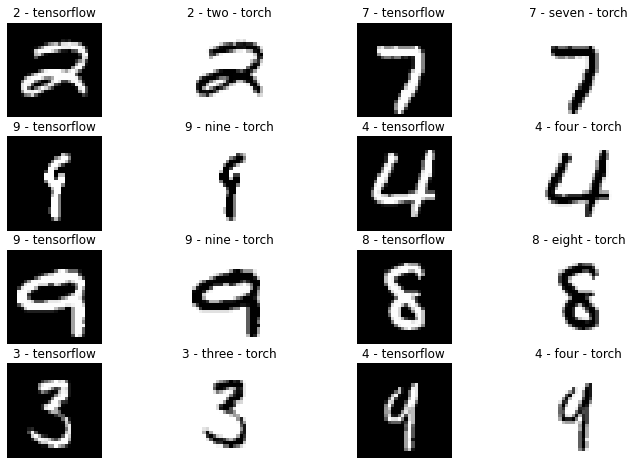

In [50]:
fig = plt.figure(figsize=(12, 8))
row, col =  4, 4
for i in range(1, row*col +1, 2):
  idx = np.random.randint(0, len(test))
  fig.add_subplot(row, col, i)
  plt.imshow(X_test_tf[idx], cmap='gray')
  plt.title(f'{y_test_tf[idx]} - tensorflow')
  plt.axis(False)
  fig.add_subplot(row, col, i+1)
  img, label = test[idx]
  label = test.classes[label]
  plt.imshow(img.squeeze(), cmap='gray_r')
  plt.title(f'{label} - torch')
  plt.axis(False)

##**3.Make prediction with each model**

In [53]:
def accuracy_fn(true, pred):
  correct = np.equal(true, pred)
  return (np.sum(correct) / len(true)) * 100

In [125]:
pred_tf = model_tf(X_test_tf)
pred_tf = np.argmax(pred_tf, 1)

accuracy_tf = accuracy_fn(y_test_tf, pred_tf)
print(f"Tensorflow Model accuracy is: {accuracy_tf}")

Tensorflow Model accuracy is: 94.33


In [164]:
pred_torch = []
y_test_torch = []
accuracy = 0

with torch.no_grad():
  for X, y in test_torch:
      X, y = X.to(device), y.to(device)
      pred = torch.argmax(model_torch(X), dim=1)
      y, pred = y.cpu().numpy(), pred.cpu().numpy()
      accuracy += accuracy_fn(y, pred)

      # save each batch label and predicted label in new numpy array
      y_test_torch = np.concatenate([y_test_torch, y])
      pred_torch = np.concatenate([pred_torch, pred])

# accuracy_torch = (accuracy / len(test_torch))

# now we can use those numpy array to calculate accuracy in different way
accuracy_torch = accuracy_fn(y_test_torch, pred_torch)
print(f"Pytorch Model accuracy is: {accuracy_torch}")

Pytorch Model accuracy is: 98.15


##**4.View misclassified item**
- if we subsract label and prediction answer for correct prediction will be zero
- `np.nonzero()` return index of element which is not zero
- it will return tuple so we return it's 0 index

In [187]:
# Find index for wrong prediction in Tensorflow model
mismatch_tf = np.abs(y_test_tf - pred_tf)
mismatch_tf_idx = np.nonzero(mismatch_tf)[0]

# Find index for wrong prediction in Pytorch model
mismatch_torch = np.abs(y_test_torch - pred_torch)[0]
mismatch_torch_idx = np.nonzero(mismatch_torch)

View some wrong prediction of Tenorflow model...



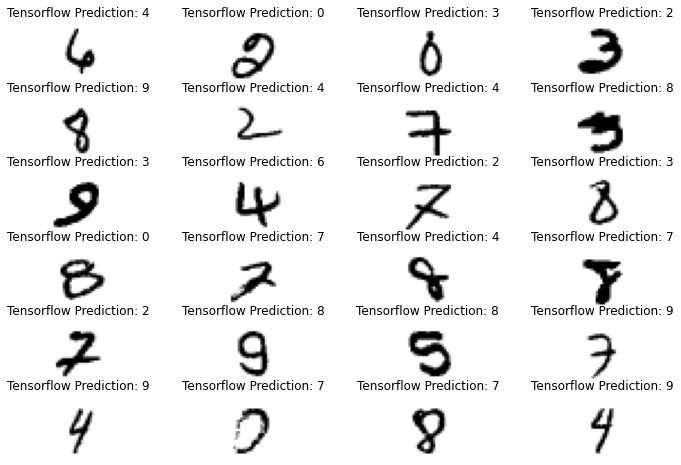

In [233]:
print("View some wrong prediction of Tenorflow model...\n")
fig = plt.figure(figsize=(12, 8))
row, col =  6, 4
for i in range(1, row*col +1):
  idx = np.random.choice(mismatch_tf_idx)
  fig.add_subplot(row, col, i)
  plt.imshow(X_test_tf[idx], cmap='gray_r')
  plt.title(f'Tensorflow Prediction: {pred_tf[idx]}')
  plt.axis(False)

View some wrong prediction of Pytorch model...



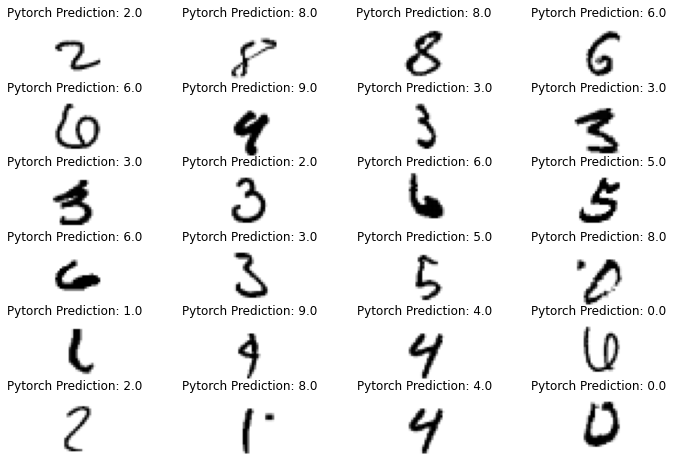

In [234]:
print("View some wrong prediction of Pytorch model...\n")
fig = plt.figure(figsize=(12, 8))
row, col =  6, 4
for i in range(1, row*col +1):
  idx = np.random.choice(mismatch_tf_idx)
  fig.add_subplot(row, col, i)
  img, label = test[idx]
  plt.imshow(img.squeeze(), cmap='gray_r')
  plt.title(f'Pytorch Prediction: {pred_torch[idx]}')
  plt.axis(False)

##**5.Create confusion metrix** 
<img src="https://www.researchgate.net/publication/329548013/figure/fig2/AS:702457277587458@1544490274450/Confusion-matrix-for-an-untargeted-adversarial-example-in-MNIST-3.png" width="500" height="450">
<img src="https://www.researchgate.net/publication/335561757/figure/fig13/AS:811758067388427@1570549613476/Confusion-matrix-for-an-ensemble-of-classifiers-trained-on-the-Fashion-MNIST-data-set.ppm" width="500">

In [220]:
# from sklearn.metrics import confusion_matrix
print("Tensorflow Confusion matrix:\n")
confusion_matrix_tf = confusion_matrix(y_test_tf, pred_tf)
print(confusion_matrix_tf)

print()
all_class_accuracy = (np.max(confusion_matrix_tf, axis=1) / np.sum(confusion_matrix_tf, axis=1)) * 100
for i, item in enumerate(all_class_accuracy):
  print(f"Accuracy for {i}: {item:.3f}")


Tensorflow Confusion matrix:

[[ 966    0    1    2    0    4    2    3    2    0]
 [   0 1113    3    2    0    0    3    1   13    0]
 [   9    2  962    9   12    2    6    8   20    2]
 [   4    2   11  936    1   16    2   12   19    7]
 [   1    0    9    0  905    0    9    4    7   47]
 [  10    3    1   15    1  825   13    1   15    8]
 [  12    3    5    1   10   12  913    0    2    0]
 [   3    8   27    3    6    1    0  947    6   27]
 [   6    3    5   11    4   14    6    7  912    6]
 [   7    6    1    9   18    1    1    4    8  954]]

Accuracy for 0: 98.571
Accuracy for 1: 98.062
Accuracy for 2: 93.217
Accuracy for 3: 92.673
Accuracy for 4: 92.159
Accuracy for 5: 92.489
Accuracy for 6: 95.303
Accuracy for 7: 92.121
Accuracy for 8: 93.634
Accuracy for 9: 94.549


In [221]:
print("Pytorch Confusion matrix\n")
confusion_matrix_torch = confusion_matrix(y_test_torch, pred_torch)
print(confusion_matrix_torch)

print()
all_class_accuracy = (np.max(confusion_matrix_torch, axis=1) / np.sum(confusion_matrix_torch, axis=1)) * 100
for i, item in enumerate(all_class_accuracy):
  print(f"Accuracy for {i}: {item:.3f}")

Pytorch Confusion matrix

[[ 972    0    2    0    0    0    3    1    2    0]
 [   0 1123    2    1    0    0    5    1    3    0]
 [   1    4 1018    0    3    0    1    5    0    0]
 [   0    0    3  988    0   10    0    7    2    0]
 [   1    0    3    0  965    0    3    0    2    8]
 [   1    0    0    2    0  882    2    1    2    2]
 [   6    3    1    0    2    5  937    0    4    0]
 [   1    1   14    3    0    0    0 1009    0    0]
 [   7    0    4    0    4    5    1    5  944    4]
 [   4    5    0    2    7    2    0   10    2  977]]

Accuracy for 0: 99.184
Accuracy for 1: 98.943
Accuracy for 2: 98.643
Accuracy for 3: 97.822
Accuracy for 4: 98.269
Accuracy for 5: 98.879
Accuracy for 6: 97.808
Accuracy for 7: 98.152
Accuracy for 8: 96.920
Accuracy for 9: 96.829


##**6.Classification Report**
**precision, recall, F1score**

<img src="https://www.researchgate.net/publication/330174519/figure/fig1/AS:711883078258689@1546737560677/Confusion-matrix-Exemplified-CM-with-the-formulas-of-precision-PR-recall-RE.png" width="1000">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1200px-Precisionrecall.svg.png" width="500" height="600">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Sensitivity_and_specificity_1.01.svg/341px-Sensitivity_and_specificity_1.01.svg.png" width="500" height="600">

In [227]:
# from sklearn.metrics import classification_report
print("Tensorflow Classification report:\n")
report_tf = classification_report(y_test_tf, pred_tf)
print(report_tf)

Tensorflow Classification report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.93      0.94      1032
           3       0.95      0.93      0.94      1010
           4       0.95      0.92      0.93       982
           5       0.94      0.92      0.93       892
           6       0.96      0.95      0.95       958
           7       0.96      0.92      0.94      1028
           8       0.91      0.94      0.92       974
           9       0.91      0.95      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [228]:
print("Pytorch Classification report:\n")
report_torch = classification_report(y_test_torch, pred_torch)
print(report_torch)

Pytorch Classification report:

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.97      0.99      0.98      1032
         3.0       0.99      0.98      0.99      1010
         4.0       0.98      0.98      0.98       982
         5.0       0.98      0.99      0.98       892
         6.0       0.98      0.98      0.98       958
         7.0       0.97      0.98      0.98      1028
         8.0       0.98      0.97      0.98       974
         9.0       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### **- Recall and precision**

1. High recall (or sensitivity) with low precision:
  - This tells us that most of the positive examples are correctly recognized (low False Negatives) but there are a lot of false positives i.e. other classes being predicted as our class in question. 

2. Low recall (or sensitivity) with high precision:
  - Our classifier is missing a lot of positive examples (high FN) but those we predaict as positive are indeed positive (low False Positives)


<img src="https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-30%20at%2011.11.12.png" width="500">


<img src="https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-30%20at%2011.11.22.png" width="500">



